
# Chapter 8



# Lab: Tree-Based Methods
We import some of our usual libraries at this top
level.

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS


We also  collect the new imports
needed for this lab.

In [238]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART


## Fitting Classification Trees

We first use classification trees to analyze the  `Carseats`  data set.

> In these data, `Sales` is a continuous variable, and so we begin
by recoding it as a binary variable. 

We use the `where()`function to create a variable, called `High`, which takes on a
value of `Yes` if the `Sales` variable exceeds 8, and takes
on a value of `No` otherwise.

- https://islp.readthedocs.io/en/latest/datasets/Carseats.html

In [239]:
Carseats = load_data('Carseats')
# ?np.where
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

Carseats.info()

print("\n \n",Carseats.describe().T)
Carseats.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB

 
              count        mean         std   min     25%     50%     75%  \
Sales        400.0    7.496325    2.824115   0.0    5.39    7.49    9.32   
CompPrice    400.0  124.975000   15.334512  77.0  115.00  125.00  135.00   
Income       400.0   68.657500   27.9860

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [273]:
#!pip install ydata-profiling
#!pip install --upgrade ipywidgets

from ydata_profiling import ProfileReport
# Generate the profiling report
profile = ProfileReport(Carseats, 
                        title="Carseats Data Profiling Report", 
                        explorative=True)

# Save the report to an HTML file
profile.to_file("Carseats_Profiling_Report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 193.72it/s]


We now use `DecisionTreeClassifier()`  to fit a classification tree in
order to predict `High` using all variables but `Sales`.
To do so, we must form a model matrix as we did when fitting regression
models.  

In [241]:
# help(MS)
model = MS(Carseats.columns.drop('Sales'), intercept=True)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)
D
#X


,intercept,CompPrice,Income,Advertising,Population,Price,ShelveLoc[Good],ShelveLoc[Medium],Age,Education,Urban[Yes],US[Yes]
0,1.0,138,73,11,276,120,0.0,0.0,42,17,1.0,1.0
1,1.0,111,48,16,260,83,1.0,0.0,65,10,1.0,1.0
2,1.0,113,35,10,269,80,0.0,1.0,59,12,1.0,1.0
3,1.0,117,100,4,466,97,0.0,1.0,55,14,1.0,1.0
4,1.0,141,64,3,340,128,0.0,0.0,38,13,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,138,108,17,203,128,1.0,0.0,33,14,1.0,1.0
396,1.0,139,23,3,37,120,0.0,1.0,55,11,0.0,1.0
397,1.0,162,26,12,368,159,0.0,1.0,40,18,1.0,1.0
398,1.0,100,79,7,284,95,0.0,0.0,50,12,1.0,1.0


We have converted `D` from a data frame to an array `X`, which is needed in some of the analysis below. We also need the `feature_names` for annotating our plots later.

There are several options needed to specify the  classifier,
such as `max_depth` (how deep to grow the tree), `min_samples_split`
(minimum number of observations in a node to be eligible for splitting)
and `criterion` (whether to use Gini or cross-entropy as the split criterion).
We also set `random_state` for reproducibility; ties in the split criterion are broken at random.

In [242]:
# help(DTC)
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In our discussion of qualitative features in Section 3.3,
we noted that for a linear regression model such a feature could be
represented by including a matrix of dummy variables (one-hot-encoding) in the model
matrix, using the formula notation of `statsmodels`.
As mentioned in Section 8.1, there is a more
natural way to handle qualitative features when building a decision
tree, that does not require such dummy variables; each split amounts to partitioning the levels into two groups.
However, **the `sklearn` implementation of decision trees does not take
advantage of this approach; instead it simply treats the one-hot-encoded levels as separate variables**.

In [243]:
# ?accuracy_score # y_true, y_pred
# help(clf.predict) # the predicted class for each sample in X is returned.
accuracy_score(High, clf.predict(X))
#dir(accuracy_score)

0.79

- Accuracy score - https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.accuracy_score.html

With only the default arguments, the training error rate is
21%.
For classification trees, we can
access the value of the deviance using `log_loss()`,
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the $m$th terminal
node that belong to the $k$th class.

In [244]:
#help(log_loss)
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev


0.4710647062649358

This is closely related to the *entropy*, defined in (8.7).
A small deviance indicates a
tree that provides a good fit to the (training) data.

One of the most attractive properties of trees is that they can
be graphically displayed. Here we use the `plot()`  function
to display the tree structure.

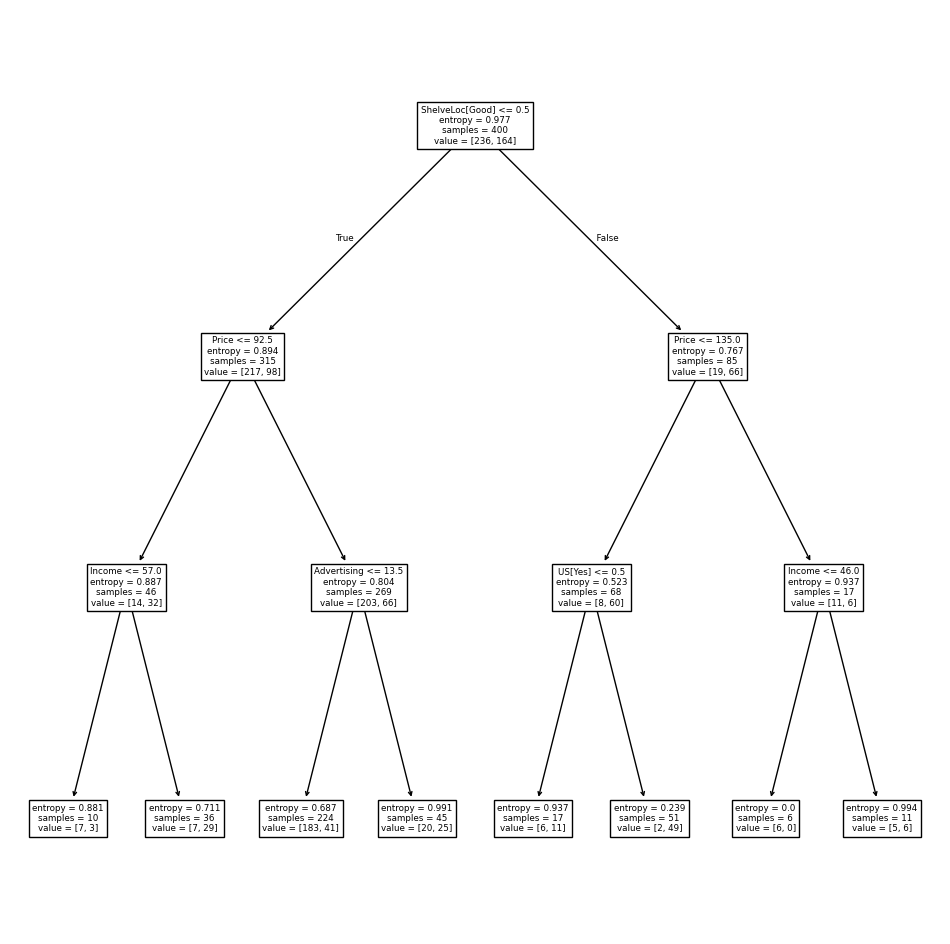

In [245]:
# help(plot_tree)
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


The most important indicator of `Sales` appears to be `ShelveLoc`.

We can see a text representation of the tree using
`export_text()`, which displays the split
criterion (e.g. `Price <= 92.5`) for each branch.
For leaf nodes it shows the overall prediction  
(`Yes` or `No`).
 We can also see the number of observations in that
leaf that take on values of `Yes` and `No` by specifying  `show_weights=True`.

In [246]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply
computing the training error. We split the observations into a
training set and a test set, build the tree using the training set,
and evaluate its performance on the test data. This pattern is
similar to that in Chapter 6, with the linear models
replaced here by decision trees --- the code for validation
is almost identical. This approach leads to correct predictions
for 68.5% of the locations in the test data set.

In [247]:
#help(skm.ShuffleSplit)
validation = skm.ShuffleSplit(n_splits=1,       # Number of re-shuffling & splitting iterations.
                              test_size=200,    #  If float b/w 0.0 & 1.0 - prop. of the data to include in the test split. If int - absolute number of test samples. 
                              random_state=0    # Controls the randomness of the training and testing indices produced.
                              ) # Yields indices to split data into training and test sets.

print(dir(validation))

# help(skm.cross_validate)
results = skm.cross_validate(clf,               # estimator
                             D,                 # X
                             High,              # y
                             cv=validation      # int, cross-validation generator or an iterable. Determines the cross-validation splitting strategy. default=None. 
                             )

results['test_score']                           # accuracy score 


['_BaseShuffleSplit__metadata_request__split', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_default_test_size', '_get_default_requests', '_get_metadata_request', '_iter_indices', 'get_metadata_routing', 'get_n_splits', 'n_splits', 'random_state', 'split', 'test_size', 'train_size']


array([0.685])

Next, we consider whether pruning the tree might lead to improved
classification performance. We first split the data into a training and
test set. We will use cross-validation to prune the tree on the training
set, and then evaluate the performance of the pruned tree on the test
set.

In [248]:
# help(skm.train_test_split)

(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)


# dir(skm.train_test_split)

We first refit the full tree on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.


In [249]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))


0.715

Next we use the `cost_complexity_pruning_path()` method of
`clf` to extract cost-complexity values.

- [Cross validation](https://www.youtube.com/watch?v=hoNpvry0370&ab_channel=TheDataPost)

In [250]:
# help(clf.cost_complexity_pruning_path) # Compute the pruning path during Minimal Cost-Complexity Pruning.

ccp_path = clf.cost_complexity_pruning_path(X_train,High_train)
print(ccp_path)

# help(skm.KFold) # Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)


{'ccp_alphas': array([0.        , 0.01622556, 0.0171946 , 0.0180482 , 0.0180482 ,
       0.01991688, 0.02012073, 0.02070855, 0.02193427, 0.0219518 ,
       0.02220877, 0.02274806, 0.02417233, 0.02588672, 0.02714959,
       0.02735525, 0.02900052, 0.02906078, 0.03209543, 0.04499252,
       0.06236632, 0.10024835]), 'impurities': array([0.        , 0.01622556, 0.05061477, 0.06866297, 0.08671117,
       0.12654492, 0.14666566, 0.16737421, 0.18930848, 0.21126028,
       0.25567782, 0.27842588, 0.32677055, 0.35265727, 0.43410604,
       0.54352706, 0.57252758, 0.65970991, 0.72390076, 0.8138858 ,
       0.87625212, 0.97650047])}


This yields a set of impurities and $\alpha$ values
from which we can extract an optimal one by cross-validation.

In [251]:
# help(skm.GridSearchCV)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},     # alpha values
                        refit=True,                             # Refit an estimator using the best found parameters on the whole dataset.
                        cv=kfold,                               # 10 fold
                        scoring='accuracy') # Exhaustive search over specified parameter values for an estimator.
grid.fit(X_train, High_train)
print(dir(grid))
grid.best_score_


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_check_refit_for_multimetric', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_format_results', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_routed_params_for_fit', '_get_scorers', '_get_tags', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_run_search', '_select_best_index', '_sk_visual_block_', '

0.6849999999999999

Let’s take a look at the pruned true.

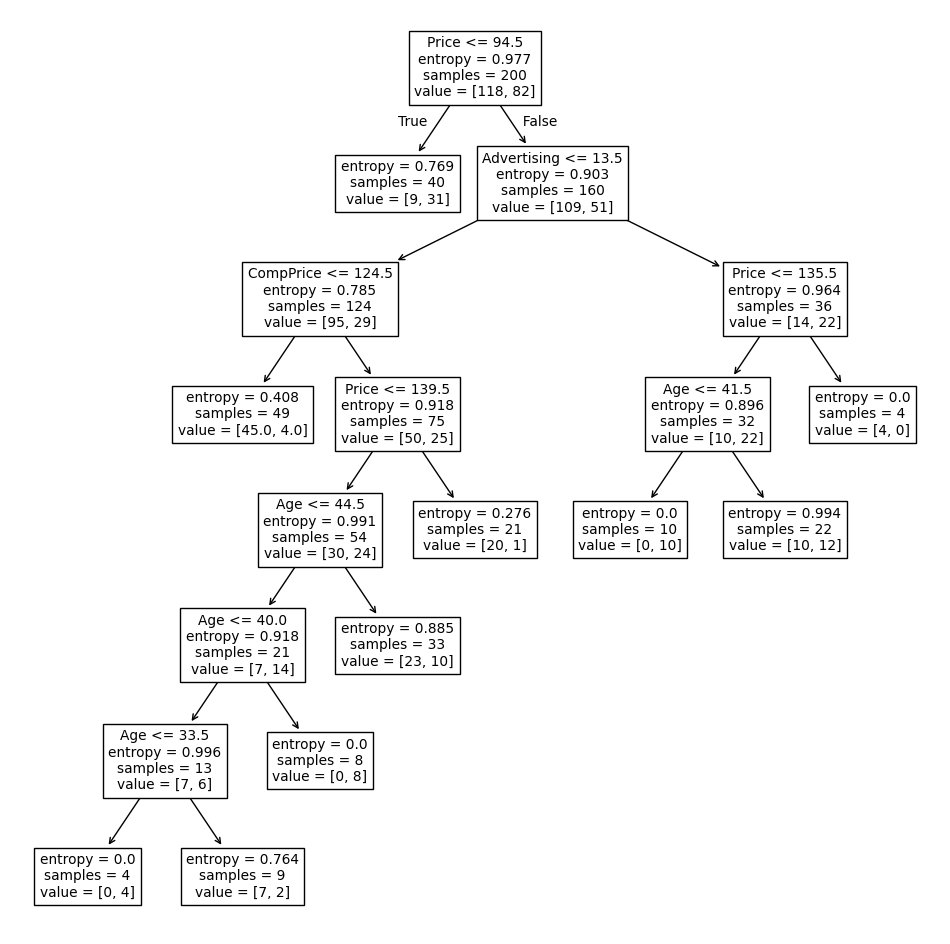

In [252]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);


This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [253]:
best_.tree_.n_leaves


10

The tree with 30 terminal
nodes results in the lowest cross-validation error rate, with an accuracy of
68.5%. How well does this pruned tree perform on the test data set? Once
again, we apply the `predict()`  function.

In [254]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
# help(confusion_table)

confusion = confusion_table(best_.predict(X_test), # predicted_labels
                            High_test              # true_labels
                            )
confusion


0.68


Truth,No,Yes
Predicted,,
No,98,44
Yes,20,38


Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). So cross-validation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

  

## Fitting Regression Trees
Here we fit a regression tree to the  `Boston`  data set. The
steps are similar to those for classification trees.

- Data [Dictionary](https://islp.readthedocs.io/en/latest/datasets/Boston.html)


In [255]:
Boston = load_data("Boston")
Boston.info()
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [256]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)


Having formed  our training  and test data sets, we fit the regression tree.

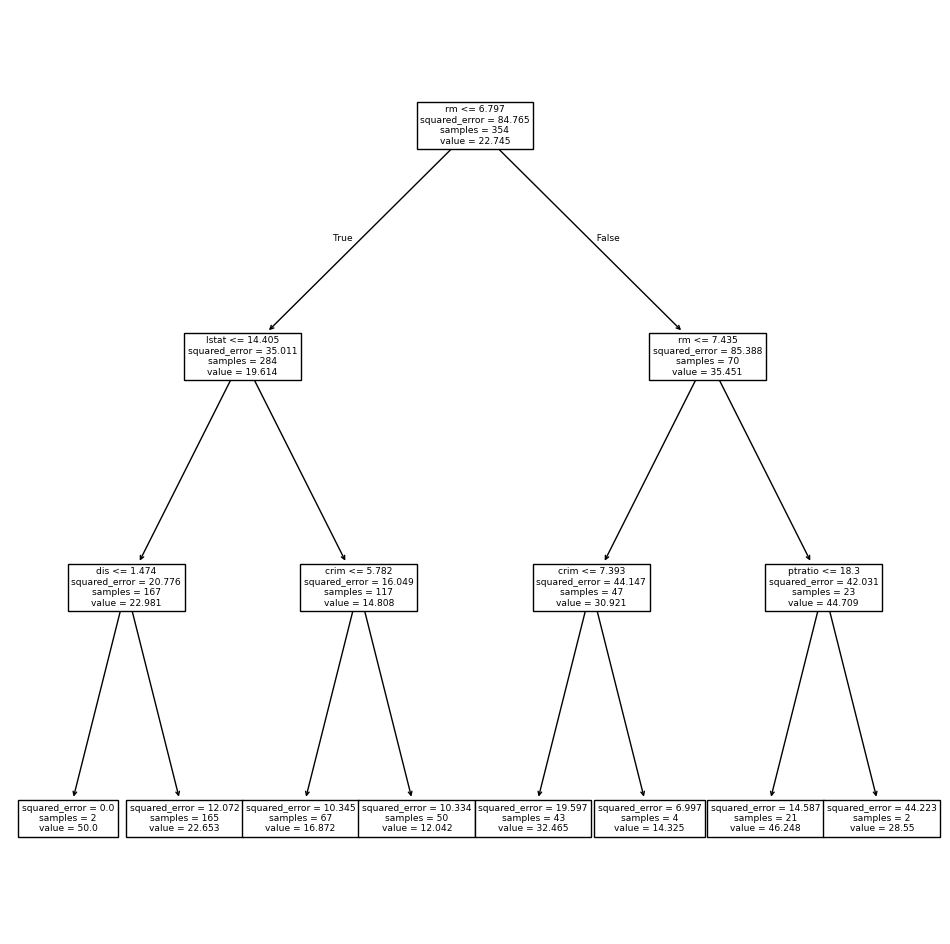

In [257]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);


The variable `lstat` measures the percentage of individuals with
lower socioeconomic status. The tree indicates that lower
values of `lstat` correspond to more expensive houses.
The tree predicts a median house price of $12,042 for small-sized homes (`rm < 6.8`), in
suburbs in which residents have low socioeconomic status (`lstat  > 14.4`) and the crime-rate is moderate (`crim > 5.8`).

Now we use the cross-validation function to see whether pruning
the tree will improve performance.

In [258]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


In keeping with the cross-validation results, we use the pruned tree
to make predictions on the test set.

In [259]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)


28.06985754975404

In other words, the test set MSE associated with the regression tree
is 28.07.  The square root of
the MSE is therefore around
5.30,
indicating that this model leads to test predictions that are within around
$5300
of the true median home value for the suburb.

Let’s plot the best tree to see how interpretable it is.

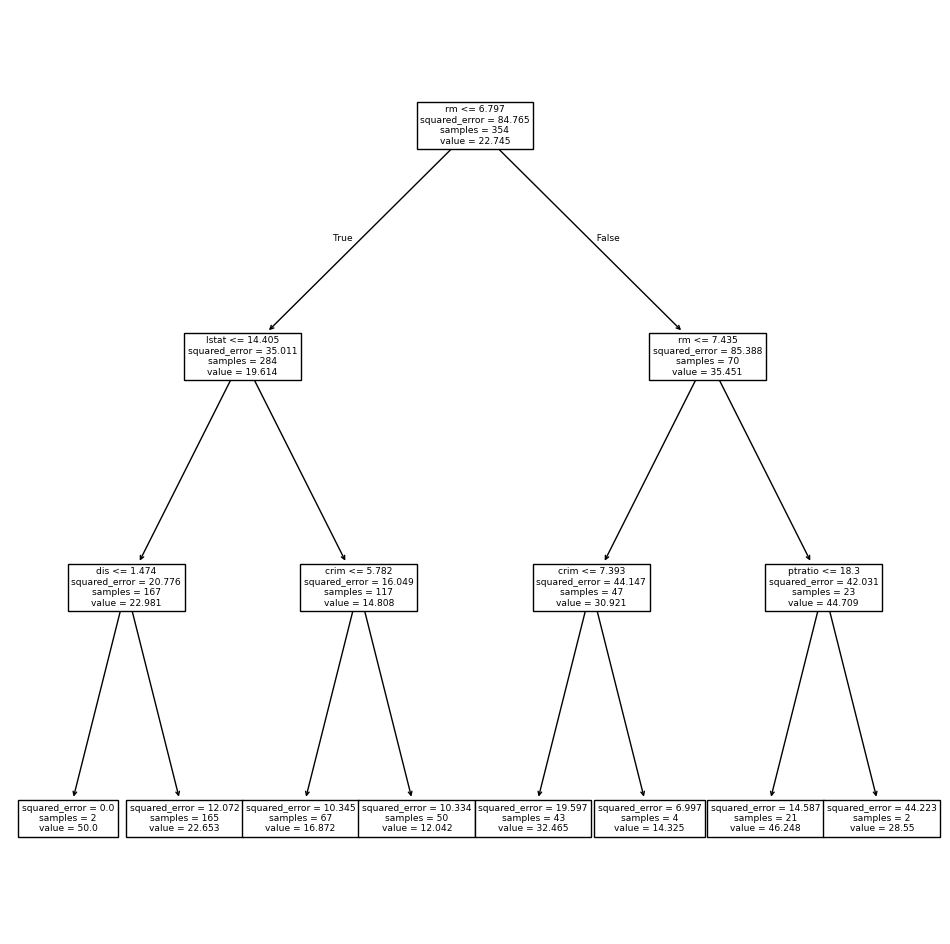

In [260]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);


## Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

In [261]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)


RandomForestRegressor(max_features=12, random_state=0)

The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

14.684333796052627

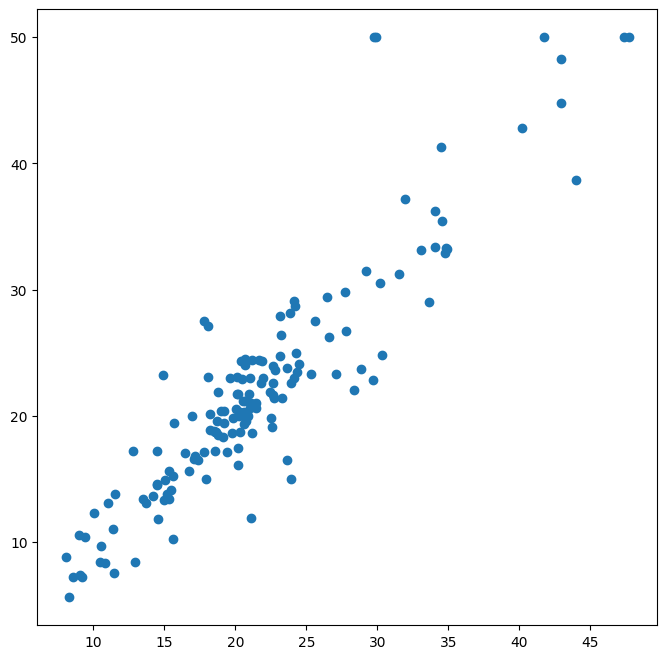

In [262]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


The test set MSE associated with the bagged regression tree is
14.63, about half that obtained using an optimally-pruned single
tree.  We could change the number of trees grown from the default of
100 by
using the `n_estimators` argument:

In [263]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.565312103157904

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `max_features=6`.

In [264]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


19.998839111842113

The test set MSE is 20.04;
this indicates that random forests did somewhat worse than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [265]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.353808
rm,0.334349
ptratio,0.069519
crim,0.056386
indus,0.053183
dis,0.043762
nox,0.033085
tax,0.025047
age,0.019238
rad,0.005169


 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees (this was plotted in Figure 8.9 for a model fit to the `Heart` data).

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Boosting

Here we use `GradientBoostingRegressor()` from `sklearn.ensemble`
to fit boosted regression trees to the `Boston` data
set. For classification we would  use `GradientBoostingClassifier()`.
The argument `n_estimators=5000`
indicates that we want 5000 trees, and the option
`max_depth=3` limits the depth of each tree. The
argument `learning_rate` is the $\lambda$
mentioned earlier in the description of boosting.

In [266]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

We can see how the training error decreases with the `train_score_` attribute.
To get an idea of how the test error decreases we can use the
`staged_predict()` method to get the predicted values along the path.

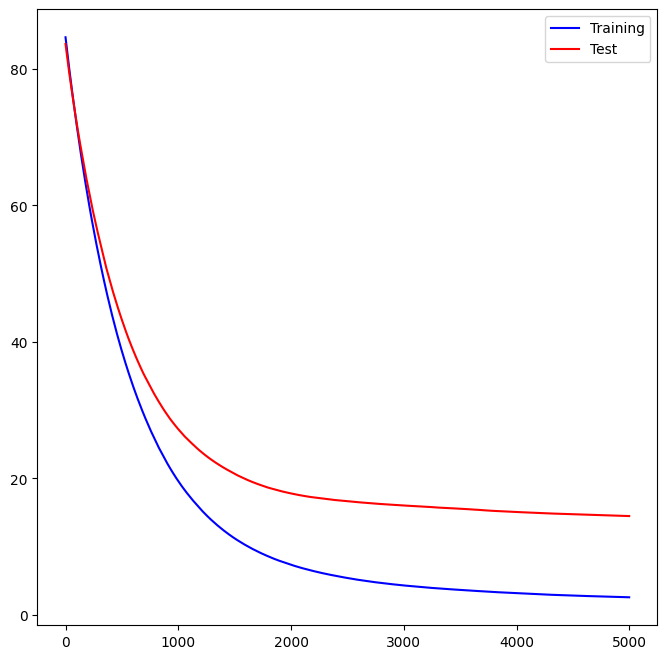

In [267]:
# Initialize an array to store test error for each stage of boosting
test_error = np.zeros_like(boost_boston.train_score_)

# Iterate over each stage of predictions (staged_predict gives the predictions at each boosting stage)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)                  # Calculate Mean Squared Error (MSE) for the test set    


plot_idx = np.arange(boost_boston.train_score_.shape[0])        # Create an index array corresponding to the boosting iterations

ax = subplots(figsize=(8,8))[1]

# Plot the training error (stored in `boost_boston.train_score_`) over the boosting iterations
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')

# Plot the test error calculated above over the boosting iterations
ax.plot(plot_idx,
        test_error,
        'r',                                                    # Red line for test error
        label='Test')
ax.legend();

We now use the boosted model to predict `medv` on the test set:

In [268]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.478980532887332

 The test MSE obtained is 14.48,
similar to the test MSE for bagging. If we want to, we can
perform boosting with a different value of the shrinkage parameter
$\lambda$ in  (8.10). The default value is 0.001, but
this is easily modified.  Here we take $\lambda=0.2$.

In [269]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.501514553719568

In this case, using $\lambda=0.2$ leads to a almost the same test MSE
as when using $\lambda=0.001$.



## Bayesian Additive Regression Trees

In this section we demonstrate a  `Python` implementation of BART found in the
`ISLP.bart` package. We fit a  model
to the `Boston` housing data set. This `BART()` estimator is
designed for quantitative outcome variables, though other implementations are available for
fitting logistic and probit models to categorical outcomes.

In [270]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)


BART(burnin=5, ndraw=15, random_state=0)

On this data set, with this split into test and training, we see that the test error of BART is similar to that of  random forest.

In [271]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)


22.145009458109225

We can check how many times each variable appeared in the collection of trees.
This gives a summary similar to the variable importance plot for boosting and random forests.

In [272]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion


crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64